### Corrélation entre la durée du film et la complexité émotionnelle (Florian ze beste)

Les films plus longs (plus de 2 heures) présentent-ils des arcs émotionnels plus complexes que les films plus courts ? Le max minute c’est 300min, 4h30
Hypothèse : Les films longs ont plus d'espace narratif pour développer des variations émotionnelles. (Avec les time steps c’est hyper quantifiable askip) 
On peut regarder la différence d’émotions entre time step, on peut voir à quel point y’a des variations, on peut regarder si ces variations changent beaucoup avec des catégories de films qui sont plus longues (2h+) et moins que ca 


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import pearsonr

import plotly.express as px
import pandas as pd
from scipy.stats import ttest_ind
import plotly.io as pio



In [4]:
# Define data path constants
DATA_PATH_EMOTIONS = "../../../data/emotions_interpolated_20.pkl"
DATA_PATH_OLD_MOVIE = "../../../data/our_movie_data.csv"
DATA_PATH_MOVIE = "../../../data/final_dataset.csv"



In [5]:


def load_emotions_data(path):
    with open(path, 'rb') as f:
        df = pickle.load(f)
    return df

df = load_emotions_data(DATA_PATH_EMOTIONS)
df.head(2)


,anger,disgust,fear,joy,neutral,sadness,surprise,Wikipedia_movie_ID,timestep
0,0.008854,0.029581,0.002972,0.115284,0.753907,0.025629,0.063773,3333,0
1,0.020809,0.070973,0.033560,0.082080,0.771024,0.012630,0.008924,3333,1


In [6]:
DATA_PATH_OLD_MOVIE = "../../../data/our_movie_data.csv"
#"../../../data/emotions_interpolated_20.pkl"
df_old_movie = pd.read_csv(DATA_PATH_OLD_MOVIE)

df_old_movie.head(1)

,Wikipedia_movie_ID,summary,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,330,In order to prepare the role of an important o...,/m/0ktn59,Actrius,NaN,NaN,90.0,"Catalan language, Spanish Language",Spain,"Drama, Comedy-drama"


In [7]:
df_movie = pd.read_csv(DATA_PATH_MOVIE)

df_movie.head(1)

,Unnamed: 0,Wikipedia_movie_ID,summary,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,category,continent,Rating
0,1,3333,The film follows two juxtaposed families: the...,/m/0151l,The Birth of a Nation,NaN,50000000.0,190.0,"Silent film, English Language",United States of America,"Silent film, Indie, Costume drama, Epic, Black...","['Action/Adventure', 'Drama']",North America,6.1


In [9]:
df_movie_filtered = df_movie[["Wikipedia_movie_ID", "Movie_name", "Movie_runtime"]]

# Merge the datasets on the Wikipedia_movie_ID column
df_combined = pd.merge(df, df_movie_filtered, on='Wikipedia_movie_ID', how='inner')

# Display the first few rows of the combined DataFrame
df_combined.head(1)



,anger,disgust,fear,joy,neutral,sadness,surprise,Wikipedia_movie_ID,timestep,Movie_name,Movie_runtime
0,0.008854,0.029581,0.002972,0.115284,0.753907,0.025629,0.063773,3333,0,The Birth of a Nation,190.0


### 1. Idée principale :
La complexité émotionnelle d'un film peut être mesurée par la variation des émotions tout au long de ses time steps. Pour explorer la relation entre cette complexité et le runtime, vous pourriez comparer les métriques de variation émotionnelle avec la durée des films.


Analyser la complexité émotionnelle des films en fonction de leur runtime est une excellente idée. Voici une approche détaillée pour répondre à votre question :

#### 1. Idée principale :
La complexité émotionnelle d'un film peut être mesurée par la variation des émotions tout au long de ses time steps. Pour explorer la relation entre cette complexité et le runtime, vous pourriez comparer les métriques de variation émotionnelle avec la durée des films.

#### 2. Mesurer les variations émotionnelles :
Vous pouvez mesurer les variations émotionnelles en suivant ces étapes :

Écart-type des émotions : Calculez l'écart-type des valeurs pour chaque émotion sur tous les time steps d'un film. Cela donne une idée de la variabilité émotionnelle dans le temps.
Amplitudes des émotions : Calculez la différence entre les valeurs max et min pour chaque émotion au fil des time steps.
Somme des variations absolues : Pour chaque émotion, additionnez les différences absolues entre deux time steps consécutifs.

In [12]:
def calculate_emotion_metrics(df_combined):
    # Grouping data by movie (Wikipedia_movie_ID)
    grouped = df_combined.groupby("Wikipedia_movie_ID")

    # Calculation of emotional variation metrics for each movie
    emotion_metrics = grouped[["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]].agg([
        lambda x: x.max() - x.min(),  # Amplitude
        lambda x: x.std(),           # Écart-type
        lambda x: (x.diff().abs().sum())  # Somme des variations absolues
    ])

    # Flatten the columns for a clean DataFrame
    emotion_metrics.columns = ['_'.join(col).strip() for col in emotion_metrics.columns]

    # Adding runtime for each movie
    emotion_metrics["Movie_runtime"] = grouped["Movie_runtime"].first()

    return emotion_metrics

# Usage
emotion_metrics = calculate_emotion_metrics(df_combined)


In [33]:
# Visualisation des premiers résultats
print(emotion_metrics.head())

                    anger_<lambda_0>  anger_<lambda_1>  anger_<lambda_2>  \
Wikipedia_movie_ID                                                         
3333                        0.473956          0.115796          2.027033   
3746                        0.615754          0.178799          3.806343   
3837                        0.754984          0.228898          4.562311   
3947                        0.431088          0.117989          2.576864   
4227                        0.647812          0.207361          3.299061   

                    disgust_<lambda_0>  disgust_<lambda_1>  \
Wikipedia_movie_ID                                           
3333                          0.815057            0.260596   
3746                          0.668426            0.168843   
3837                          0.580861            0.140068   
3947                          0.762900            0.249842   
4227                          0.411382            0.136410   

                    disgust_<lam

In [ ]:
def calculate_metrics_per_film(df_combined):
    # Calculation of absolute variations for each emotion between the time steps
    def compute_emotion_variation(group):
        variation = group[["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]].diff().abs().sum()
        return variation.mean()  # Moyenne des variations absolues

    # Apply to groups of films (Wikipedia_movie_ID)
    metrics_per_film = (
        df_combined.groupby("Wikipedia_movie_ID")
        .apply(lambda group: pd.Series({
            "emotion_variation": compute_emotion_variation(group),
            "Movie_runtime": group["Movie_runtime"].iloc[0],
        }))
        .reset_index()
    )
    
    return metrics_per_film

# Usage
metrics_per_film = calculate_metrics_per_film(df_combined)


C:\Users\flori\AppData\Local\Temp\ipykernel_19792\1804087924.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


In [17]:
def clean_and_calculate_correlation(metrics_per_film):
    # Add a column to classify between long and short movies
    metrics_per_film["runtime_category"] = metrics_per_film["Movie_runtime"].apply(
        lambda x: "Long (> 2h)" if x > 120 else "Short (<= 2h)"
    )

    print(metrics_per_film.dtypes)

    # Apply np.isinf only to numerical columns
    numeric_columns = metrics_per_film.select_dtypes(include=[np.number]).columns
    print(np.isinf(metrics_per_film[numeric_columns]).sum())

    # Clean the NaN and inf in the columns specific to the correlation calculation
    metrics_per_film_cleaned = metrics_per_film.dropna(subset=["Movie_runtime", "emotion_variation"])

    # Supprimer les lignes contenant des inf dans ces colonnes
    metrics_per_film_cleaned = metrics_per_film_cleaned[~np.isinf(metrics_per_film_cleaned["Movie_runtime"])]
    metrics_per_film_cleaned = metrics_per_film_cleaned[~np.isinf(metrics_per_film_cleaned["emotion_variation"])]

    # Correlation computation between movie runtime and emotional variation
    correlation, p_value = pearsonr(
        metrics_per_film_cleaned["Movie_runtime"],
        metrics_per_film_cleaned["emotion_variation"]
    )

    print(f"Corrélation : {correlation:.2f}, P-value : {p_value:.3e}")

    return metrics_per_film_cleaned, correlation, p_value

# Usage
metrics_per_film_cleaned, correlation, p_value = clean_and_calculate_correlation(metrics_per_film)

Wikipedia_movie_ID      int64
emotion_variation     float64
Movie_runtime         float64
runtime_category       object
dtype: object
Wikipedia_movie_ID    0
emotion_variation     0
Movie_runtime         0
dtype: int64
Wikipedia_movie_ID    0
emotion_variation     0
Movie_runtime         0
runtime_category      0
dtype: int64
0
0
Corrélation : 0.15, P-value : 8.008e-143


#### Interprétation :
Corrélation de 0.15 : Une corrélation aussi faible suggère qu'il n'y a qu'une relation modeste entre la durée du film et la variation émotionnelle. Autrement dit, bien que la durée du film semble avoir un effet sur la complexité émotionnelle, cet effet est assez faible.

P-value de 8.008e-143 : Ce p-value très bas indique que le résultat est hautement significatif. Cela signifie qu'il y a très peu de chances que cette corrélation apparaisse par hasard, mais la faiblesse de la corrélation suggère que d'autres facteurs non mesurés peuvent également influencer la complexité émotionnelle.

#### 3. Relation avec le runtime :
On peut analyser les relations entre ces métriques et la durée des films :

Corrélation : Calculez les coefficients de corrélation entre le runtime et chaque mesure de variation émotionnelle.
Visualisation : Faites des graphiques pour explorer les tendances.

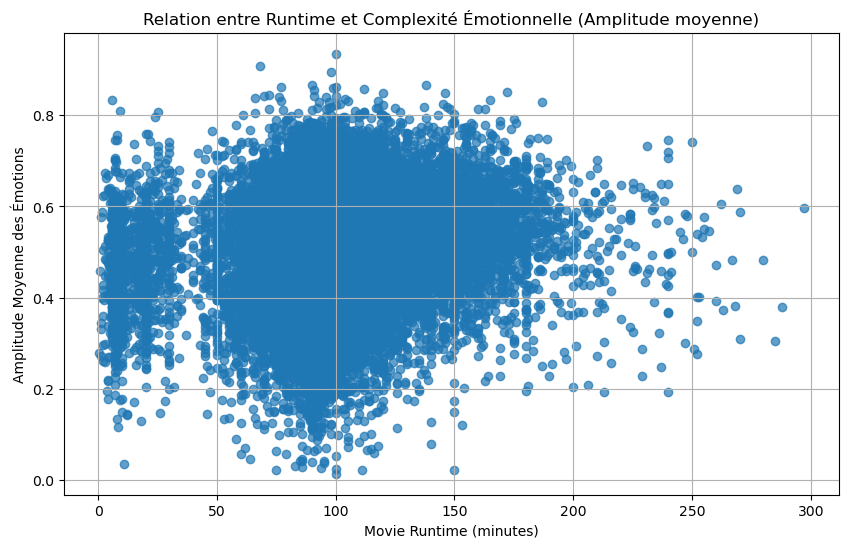

In [20]:
def plot_runtime_vs_emotion_amplitude(emotion_metrics):
    # Calculate mean amplitude of emotions
    emotion_metrics["mean_amplitude"] = emotion_metrics[[col for col in emotion_metrics.columns if "lambda_0" in col]].mean(axis=1)

    # Plot the relationship between movie runtime and mean amplitude of emotions
    plt.figure(figsize=(10, 6))
    plt.scatter(emotion_metrics["Movie_runtime"], emotion_metrics["mean_amplitude"], alpha=0.7)
    plt.title("Relation entre Runtime et Complexité Émotionnelle (Amplitude moyenne)")
    plt.xlabel("Movie Runtime (minutes)")
    plt.ylabel("Amplitude Moyenne des Émotions")
    plt.grid()
    plt.show()

# Usage
plot_runtime_vs_emotion_amplitude(emotion_metrics)


C:\Users\flori\AppData\Local\Temp\ipykernel_19792\3880290208.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




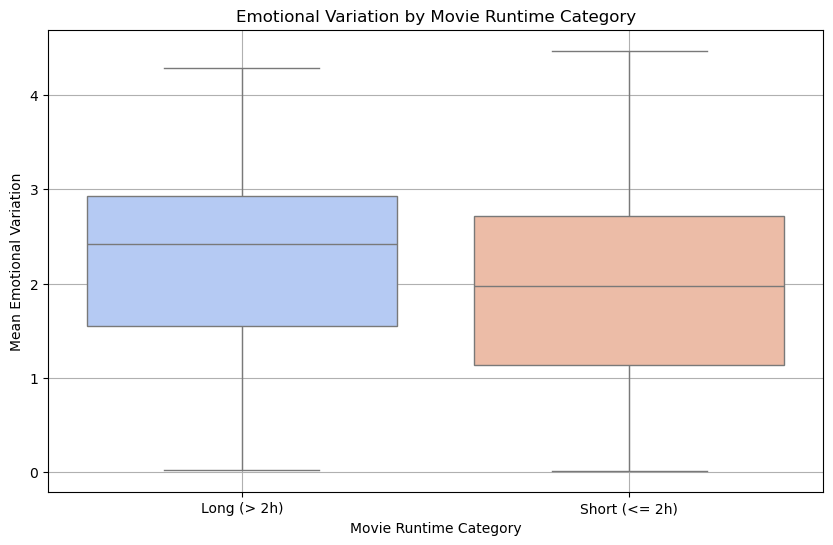

T-statistic: 22.27, P-value: 6.645e-106


In [34]:
def plot_emotion_variation_by_runtime(metrics_per_film):
    # Boxplot of emotional variations by runtime category
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x="runtime_category",
        y="emotion_variation",
        data=metrics_per_film,
        palette="coolwarm"
    )
    plt.title("Emotional Variation by Movie Runtime Category")
    plt.xlabel("Movie Runtime Category")
    plt.ylabel("Emotional Variation")
    plt.grid()
    plt.show()

    # T test between long and short movies
    long_movies = metrics_per_film[metrics_per_film["runtime_category"] == "Long (> 2h)"]["emotion_variation"]
    short_movies = metrics_per_film[metrics_per_film["runtime_category"] == "Short (<= 2h)"]["emotion_variation"]

    t_stat, p_value = ttest_ind(long_movies, short_movies, equal_var=False)
    print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.3e}")

# Usage
plot_emotion_variation_by_runtime(metrics_per_film)


In [25]:
def plot_emotional_variation_by_film_length(metrics_per_film):
    # Create a boxplot with Plotly for emotion variation by runtime category
    fig = px.box(metrics_per_film, 
                 x="runtime_category", 
                 y="emotion_variation", 
                 color="runtime_category", 
                 title="Emotional Variation by Film Length", 
                 labels={"runtime_category": "Film Length Category", 
                         "emotion_variation": "Mean Emotional Variation"},
                 color_discrete_sequence=["#636EFA", "#EF553B"])

    fig.update_layout(
        title="Emotional Variation by Film Length",
        xaxis_title="Film Length Category",
        yaxis_title="Mean Emotional Variation",
        showlegend=False
    )

    # Save the figure as an HTML file
    pio.write_html(fig, file='emotional_variation_by_film_length.html', auto_open=True)

    # Test T between long and short movies
    long_movies = metrics_per_film[metrics_per_film["runtime_category"] == "Long (> 2h)"]["emotion_variation"]
    short_movies = metrics_per_film[metrics_per_film["runtime_category"] == "Short (<= 2h)"]["emotion_variation"]

    t_stat, p_value = ttest_ind(long_movies, short_movies, equal_var=False)
    print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.3e}")

    return fig, t_stat, p_value

# Usage
fig, t_stat, p_value = plot_emotional_variation_by_film_length(metrics_per_film)


T-statistic: 22.27, P-value: 6.645e-106


Corrélation entre la durée du film et de chaque émotion

In [28]:
# Calculer les corrélations pour chaque émotion
emotions = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
correlations = []

for emotion in emotions:
    emotion_variation = f"{emotion}_variation"
    metrics_per_film_cleaned[f"{emotion}_variation"] = (
        df_combined.groupby("Wikipedia_movie_ID")[emotion]
        .apply(lambda x: x.diff().abs().sum())
    )
    cleaned_data = metrics_per_film_cleaned.dropna(subset=["Movie_runtime", emotion_variation])
    correlation, p_value = pearsonr(cleaned_data["Movie_runtime"], cleaned_data[emotion_variation])
    correlations.append({"Emotion": emotion, "Correlation": correlation, "P-value": p_value})

# Affichage des résultats
correlation_df = pd.DataFrame(correlations)
print(correlation_df)

# Visualisation avec Plotly
fig = px.bar(correlation_df, x="Emotion", y="Correlation", title="Correlation between movie runtime and emotional variation",
             labels={"Correlation": "Correlation coefficient"}, color="Correlation", color_continuous_scale="viridis")

fig.add_hline(y=0, line_dash="dash", line_color="red")

# Save the figure as an HTML file
pio.write_html(fig, file='correlation_emotional_variation.html', auto_open=True)


    Emotion  Correlation   P-value
0     anger    -0.028447  0.786638
1   disgust     0.054005  0.607154
2      fear    -0.071366  0.496637
3       joy     0.241630  0.019629
4   neutral     0.100126  0.339617
5   sadness    -0.057186  0.586117
6  surprise     0.200532  0.053938


La biggest corrélation c'est joy et surprise, corrélation positive. Corrélation négative meaning plus le film est long moins y'a de variation dans les autres emotions 